In [1]:
%load_ext autoreload
%autoreload 2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import kendalltau

from ocr.config import OCRConfig

In [2]:
config = OCRConfig(storage_root='/tmp/era5-vs-conus404')
config

OCRConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/era5-vs-conus404', vector=VectorConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/era5-vs-conus404', prefix='intermediate/fire-risk/vector/qa', output_prefix='output/fire-risk/vector/qa', debug=False), icechunk=IcechunkConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/era5-vs-conus404', prefix='output/fire-risk/tensor/qa/ocr.icechunk', debug=False), chunking=<POLYGON ((-64.054 22.428, -64.054 52.482, -128.387 52.482, -128.387 22.428,...>, coiled=CoiledConfig(tag={'Project': 'OCR'}, forward_aws_credentials=False, spot_policy='spot_with_fallback', region='us-west-2', ntasks=1, vm_type='m8g.2xlarge', scheduler_vm_type='m8g.2xlarge'), debug=False)

In [3]:
def apply_kendall_tau(x, y):
    # confirm we want to use b variant
    tau, p_value = kendalltau(x, y, variant='b')
    return pd.Series({'tau': tau, 'p_value': p_value})

In [4]:
def apply_bias(x, y):
    bias = np.mean(x - y)
    return pd.Series({'bias': bias})

In [5]:
def apply_median(x, label):
    median = np.median(x)
    return pd.Series({f'median_{label}': median})

In [6]:
def apply_mean(x, label):
    mean = np.mean(x)
    return pd.Series({f'mean_{label}': mean})

In [7]:
def fraction_zeros(x, y):
    x_fract_zero = (x == 0).sum() / len(x)
    y_fract_zero = (y == 0).sum() / len(y)
    return pd.Series({'x_fract_zero': x_fract_zero, 'y_fract_zero': y_fract_zero})

In [8]:
def apply_corr(x, y):
    corr = np.corrcoef(x, y)
    return pd.Series({'corr': corr[0, 1]})

In [9]:
config.vector.building_geoparquet_uri

PosixUPath('/tmp/era5-vs-conus404/output/fire-risk/vector/qa/geoparquet/buildings.parquet')

In [10]:
states = gpd.read_file('s3://carbonplan-risks/shapefiles/cb_2018_us_state_20m.zip')
states = states[~(states['STUSPS'].isin(['AK', 'PR', 'HI']))]

In [11]:
census_tracts = gpd.read_parquet(
    's3://carbonplan-ocr/input/fire-risk/vector/aggregated_regions/tracts/tracts.parquet'
)

In [12]:
remake_building_tract_file = False
remake_tract_stats_file = False
if remake_building_tract_file:
    building_file = gpd.read_parquet(
        's3://carbonplan-ocr/output/fire-risk/vector/production/v0.4.0/geoparquet/buildings.parquet'
    )
    building_file = building_file.drop(['bbox'], axis=1)
    # intersects will duplicate buildings that straddle multiple census tracts. we could clean this up
    # later by de-duplicating buildings
    buildings_in_census_tracts = gpd.sjoin(building_file, census_tracts[['GEOID', 'geometry']])
    buildings_in_census_tracts.to_parquet(
        's3://carbonplan-risks/shapefiles/buildings_tracts_0.4.0_geo.parquet'
    )
else:
    if remake_tract_stats_file:
        buildings_in_census_tracts = gpd.read_parquet(
            's3://carbonplan-risks/shapefiles/buildings_tracts_0.4.0_geo.parquet'
        )

        df_buildings_in_census_tracts = buildings_in_census_tracts[
            ['USFS_RPS', 'wind_risk_2011', 'wind_risk_2047', 'GEOID']
        ]
        tract_tau = df_buildings_in_census_tracts.groupby('GEOID').apply(
            lambda g: apply_kendall_tau(g['wind_risk_2011'], g['USFS_RPS'])
        )
        tract_performance_stats = census_tracts[['GEOID', 'geometry']].merge(tract_tau, on='GEOID')
        # add what fraction of the buildings have zero risk because those tracts should be removed since tau is NaN
        new_df = df_buildings_in_census_tracts.groupby('GEOID').apply(
            lambda g: fraction_zeros(g['wind_risk_2011'], g['USFS_RPS'])
        )
        tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID')
        # add correlation calculation
        new_df = df_buildings_in_census_tracts.groupby('GEOID').apply(
            lambda g: apply_corr(g['wind_risk_2011'], g['USFS_RPS'])
        )
        tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID')
        # add bias calculation
        new_df = df_buildings_in_census_tracts.groupby('GEOID').apply(
            lambda g: apply_bias(g['wind_risk_2011'], g['USFS_RPS'])
        )
        tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID')
        # add mean calculation for both x and y
        for setup in ['wind_risk_2011', 'USFS_RPS']:
            new_df = df_buildings_in_census_tracts.groupby('GEOID').apply(
                lambda g: apply_mean(g[setup], setup)
            )
            tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID')
        # add median calculation for both x and y
        for setup in ['wind_risk_2011', 'USFS_RPS']:
            new_df = df_buildings_in_census_tracts.groupby('GEOID').apply(
                lambda g: apply_median(g[setup], setup)
            )
            tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID')
        tract_performance_stats['normalized_bias'] = (
            tract_performance_stats['bias'] / tract_performance_stats['mean_USFS_RPS']
        )
        # filter out any places that are all zeros in either CP or USFS because they'll either make for NaN kendall tau or infinity in bias
        tract_performance_stats = tract_performance_stats[
            ~(tract_performance_stats['x_fract_zero'] == 1)
        ]
        tract_performance_stats = tract_performance_stats[
            ~(tract_performance_stats['y_fract_zero'] == 1)
        ]
        tract_performance_stats.to_parquet(
            's3://carbonplan-risks/shapefiles/tracts_stats_geo_0.4.0.parquet'
        )
    else:
        tract_performance_stats = gpd.read_parquet(
            's3://carbonplan-risks/shapefiles/tracts_stats_geo_0.4.0.parquet'
        )

In [13]:
def find_hotspots(quantile, tract_df):
    hot_spot_thresholds = tract_df[['bias', 'normalized_bias']].quantile(quantile, axis=0)
    bias_filter = tract_df['bias'] > hot_spot_thresholds['bias']
    normalized_bias_filter = tract_df['normalized_bias'] > hot_spot_thresholds['normalized_bias']
    return tract_df[bias_filter & normalized_bias_filter]

## Top 3 hot spot tracts are all around LA

In [14]:
hotspots = find_hotspots(0.99, tract_performance_stats)

<Axes: >

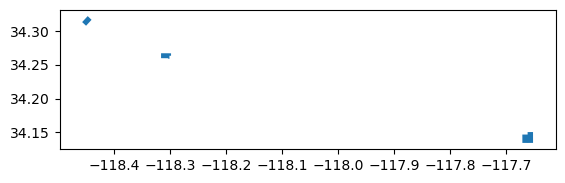

In [15]:
hotspots.plot()

In [16]:
hotspots.bounds

,minx,miny,maxx,maxy
4323,-118.315747,34.258690,-118.297917,34.266971
8511,-118.456710,34.307587,-118.439908,34.321786
8772,-117.670412,34.134514,-117.651299,34.150601


## If we lower the threshold just a smidge we can get a list of ~20 that includes a couple in New Jersey as well as Arizona

In [17]:
hotspots = find_hotspots(0.985, tract_performance_stats)

/tmp/ipykernel_8048/901926198.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hotspots.centroid.plot()


<Axes: >

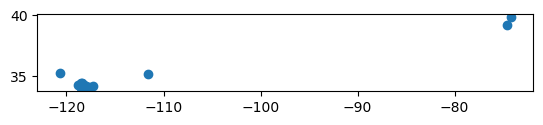

In [18]:
hotspots.centroid.plot()

In [19]:
hotspots.bounds

,minx,miny,maxx,maxy
1552,-111.630017,35.194725,-111.611942,35.210718
3026,-118.334133,34.259677,-118.315727,34.272397
3600,-118.447719,34.416441,-118.429004,34.427085
3952,-120.670290,35.264066,-120.652211,35.278112
4315,-118.427822,34.286821,-118.400768,34.323189
4323,-118.315747,34.258690,-118.297917,34.266971
4447,-118.021009,34.145649,-118.005300,34.151296
5329,-118.525058,34.446375,-118.508382,34.460217
6590,-118.778896,34.271944,-118.761361,34.282489
7243,-118.248643,34.218904,-118.226836,34.238473


In [20]:
hotspots.loc[[1552, 43390, 3952]].bounds

,minx,miny,maxx,maxy
1552,-111.630017,35.194725,-111.611942,35.210718
43390,-74.222164,39.835521,-74.191164,39.863613
3952,-120.670290,35.264066,-120.652211,35.278112


In [21]:
variable_name_dict = {
    'tau': "Kendall's Tau of RPS",
    'bias': 'RPS bias (CP - WRC)',
    'corr': 'Correlation',
    'median_wind_risk_2011': 'CP median RPS',
    'median_USFS_RPS': 'WRC median RPS',
    'mean_wind_risk_2011': 'CP mean RPS',
    'mean_USFS_RPS': 'WRC mean RPS',
    'normalized_bias': 'RPS normalized bias\n((CP - WRC)/WRC)',
}
var_lims = {'tau': [-1, 1], 'bias': [-0.1, 0.1], 'normalized_bias': [-1, 1], 'corr': [-1, 1]}

cmaps = {'tau': 'PRGn', 'bias': 'RdBu_r', 'normalized_bias': 'RdBu_r', 'corr': 'PRGn'}

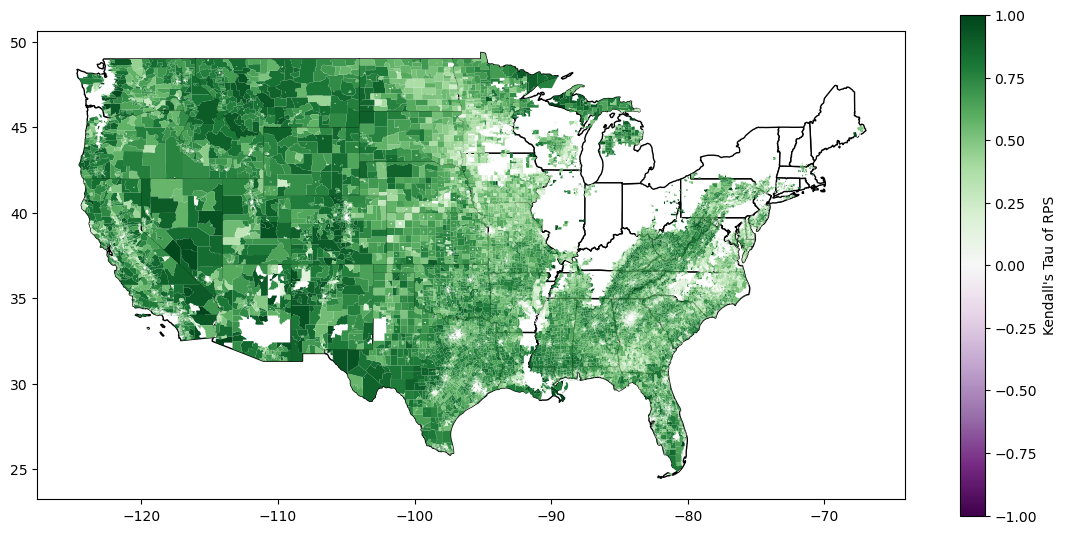

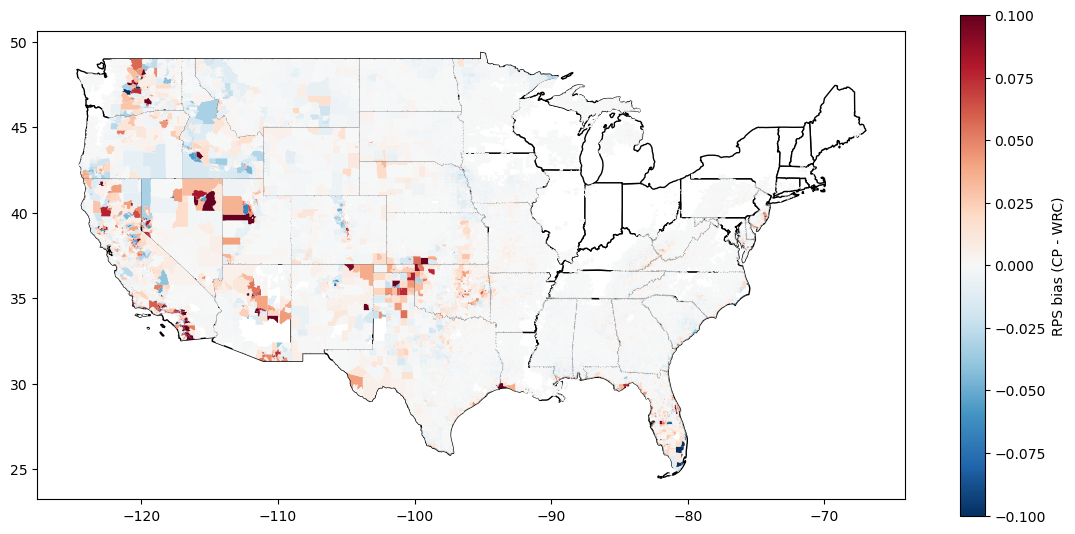

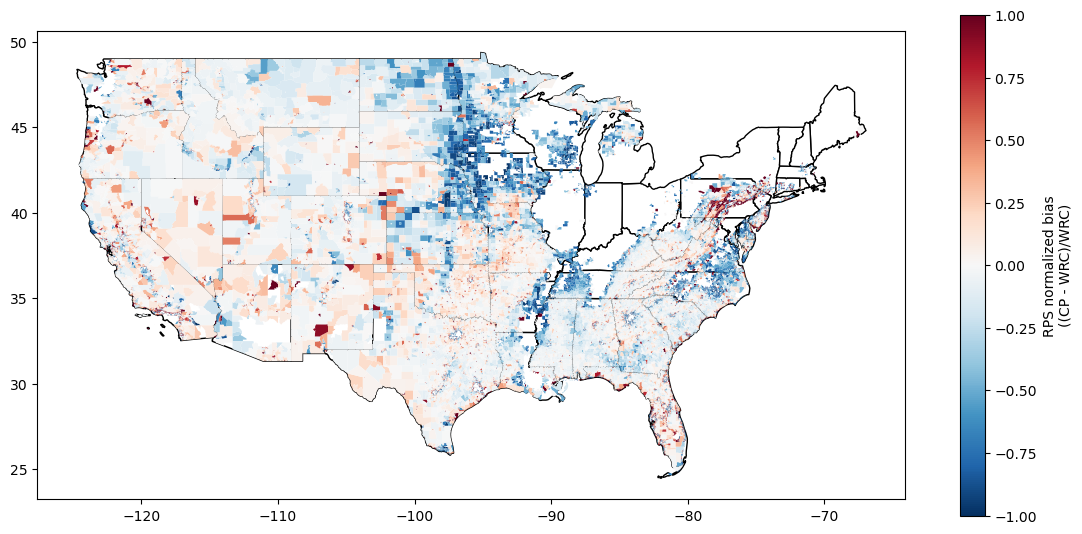

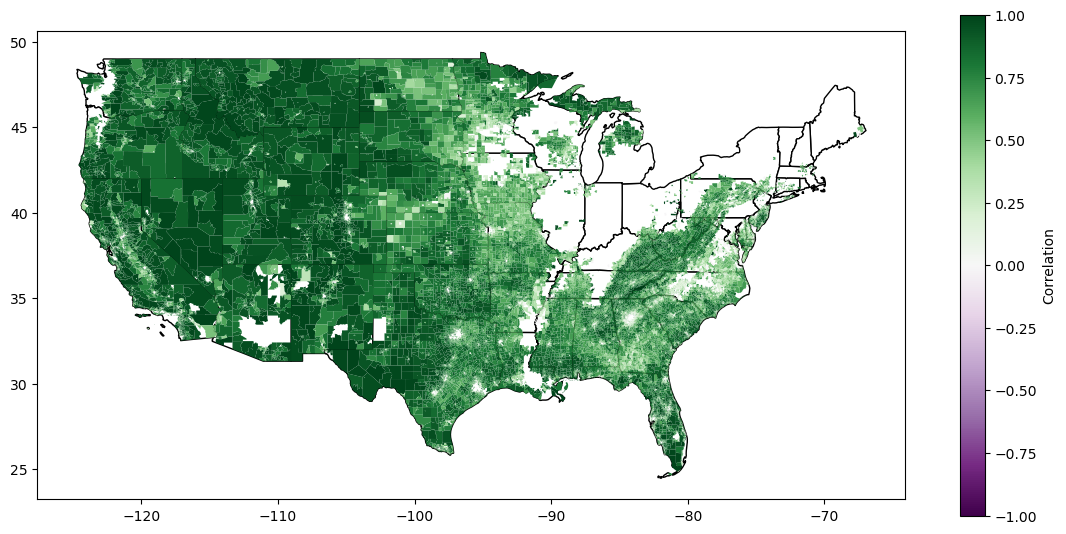

In [98]:
for variable in ['tau', 'bias', 'normalized_bias', 'corr']:
    fig, axarr = plt.subplots(figsize=(14, 10))
    states.plot(ax=axarr, color='white', edgecolor='black')
    ax = tract_performance_stats.plot(
        ax=axarr,
        column=variable,
        vmin=var_lims[variable][0],
        vmax=var_lims[variable][1],
        legend=True,
        cmap=cmaps[variable],
        legend_kwds={'shrink': 0.65, 'label': variable_name_dict[variable]},
    )

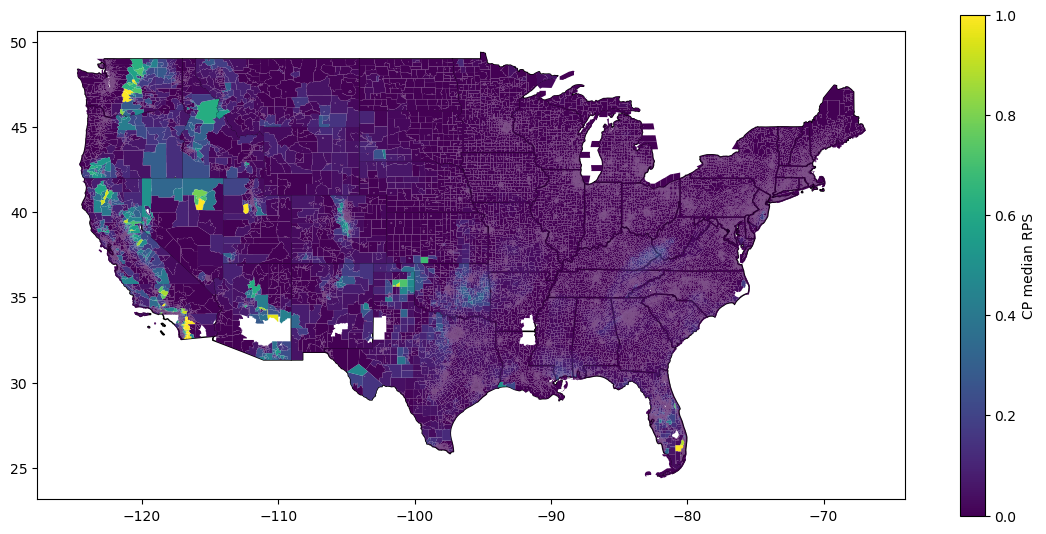

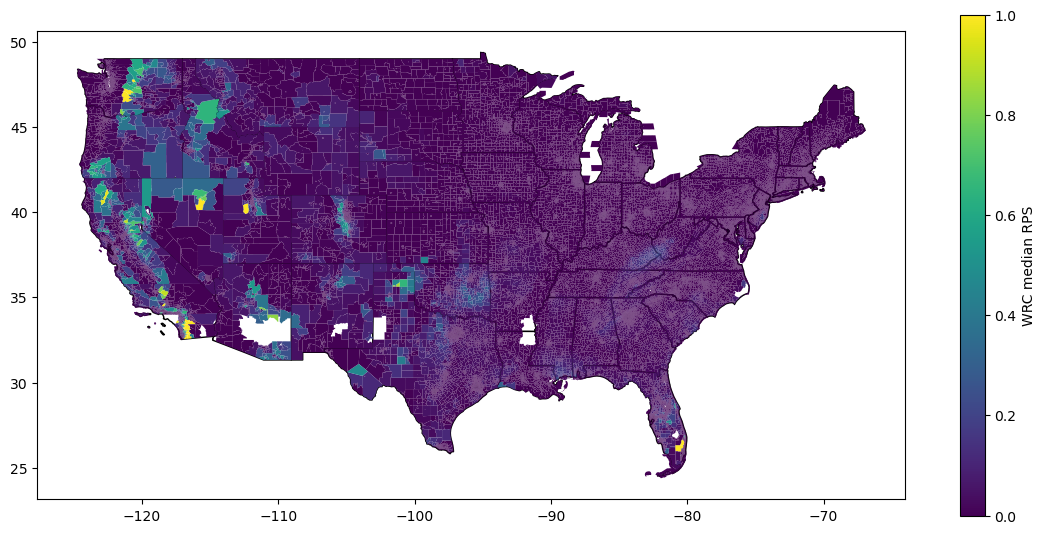

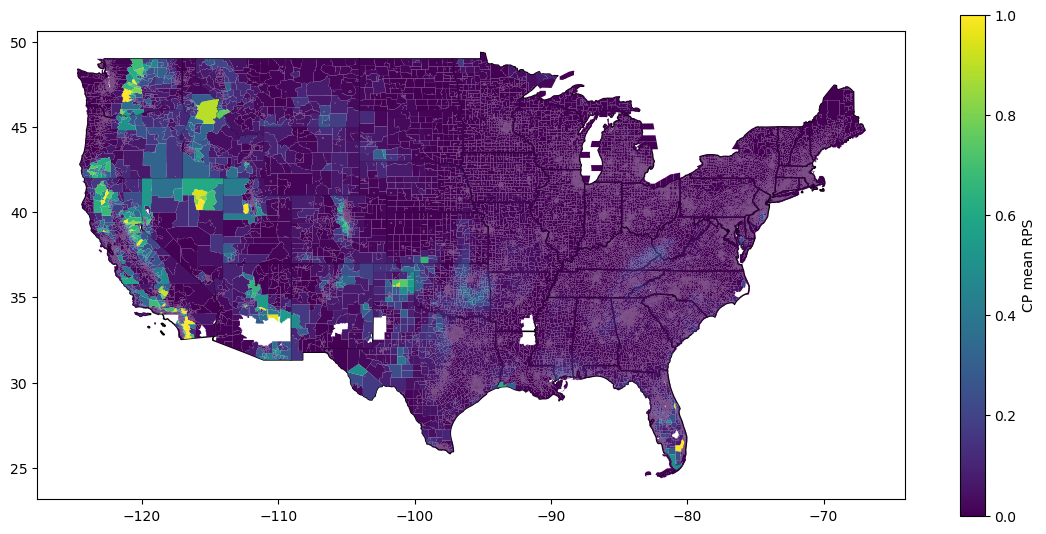

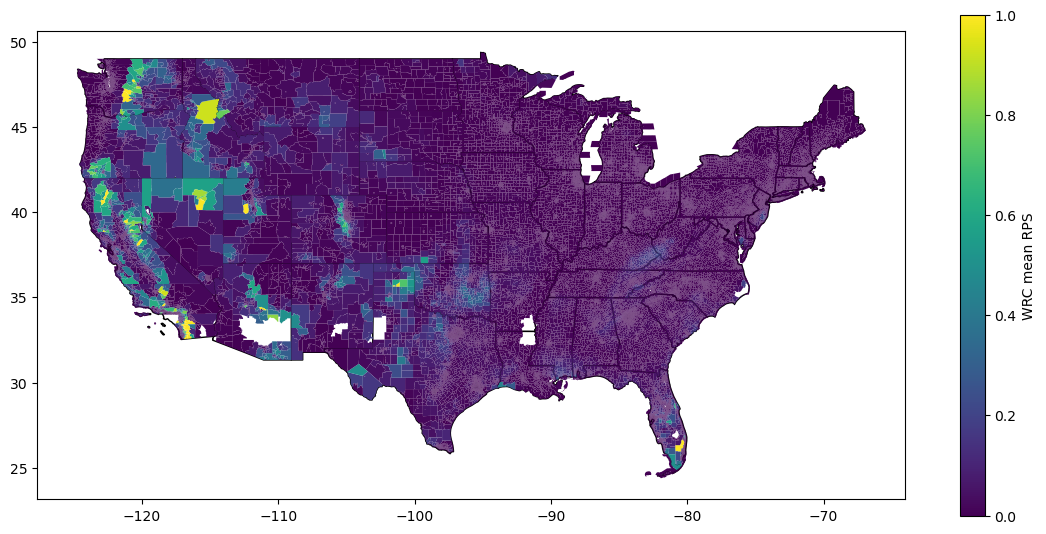

In [74]:
for variable in [
    'median_wind_risk_2011',
    'median_USFS_RPS',
    'mean_wind_risk_2011',
    'mean_USFS_RPS',
]:
    fig, axarr = plt.subplots(figsize=(14, 10))
    states.plot(ax=axarr, color='white', edgecolor='black')
    ax = tract_performance_stats.plot(
        ax=axarr,
        column=variable,
        vmin=0,
        vmax=1,
        legend=True,
        cmap='viridis',
        legend_kwds={'shrink': 0.65, 'label': variable_name_dict[variable]},
    )

In [ ]:
# histogram of biases across entire domain

<Axes: ylabel='Frequency'>

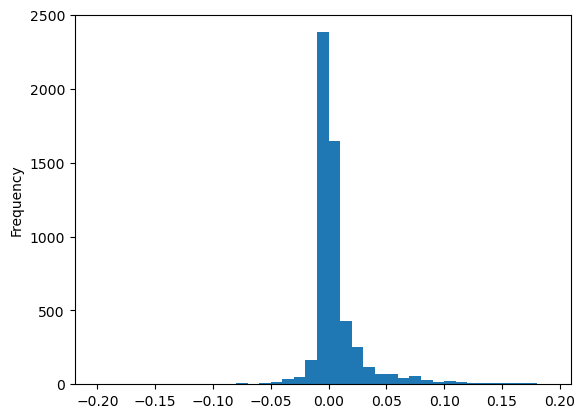

In [204]:
tract_performance_stats['bias'].plot(kind='hist', bins=np.arange(-0.2, 0.2, 0.01))

In [ ]:
# for sample census tracts (LA fires, Paradise, ...?) histograms of risk